# Importação e Carregamento dos Dados

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df_results = pd.read_csv(r'dataset\results.csv', encoding='latin-1')
df_races = pd.read_csv(r'dataset\races.csv', encoding='latin-1')
df_drivers = pd.read_csv(r'dataset\drivers.csv', encoding='latin-1')
df_constructors = pd.read_csv(r'dataset\constructors.csv', encoding='latin-1')

df = pd.merge(df_results, df_races[['race_id', 'season', 'circuit_id']], on='race_id', how='left')

print(f"Total de registos carregados: {df.shape[0]}")
df.head()

Total de registos carregados: 7600


,race_id,driver_id,constructor_id,grid,position,position_order,points,laps,status,season,circuit_id
0,1950_1,farina,alfa,1,1,1,9.0,70,Finished,1950,silverstone
1,1950_1,fagioli,alfa,2,2,2,6.0,70,Finished,1950,silverstone
2,1950_1,reg_parnell,alfa,4,3,3,4.0,70,Finished,1950,silverstone
3,1950_1,cabantous,lago,6,4,4,3.0,68,+2 Laps,1950,silverstone
4,1950_1,rosier,lago,9,5,5,2.0,68,+2 Laps,1950,silverstone


# Limpeza e pré processamento

In [ ]:
# Filtrar apenas dados da era híbrida (2014 em diante)
df_clean = df[df['season'] >= 2014].copy()

# Criar a variável ALVO (Target)
df_clean['Pontuou'] = df_clean['position_order'].apply(lambda x: 1 if x <= 10 else 0)

# TSelecionar Features
# 'constructor_id' e 'circuit_id'
features = ['grid', 'constructor_id', 'circuit_id']
target = 'Pontuou'

df_final = df_clean[features + [target]].copy()

le_constructor = LabelEncoder()
le_circuit = LabelEncoder()

df_final['constructor_id'] = le_constructor.fit_transform(df_final['constructor_id'])
df_final['circuit_id'] = le_circuit.fit_transform(df_final['circuit_id'])

df_final.dropna(inplace=True)

print("Distribuição das Classes:")
print(df_final['Pontuou'].value_counts(normalize=True))
df_final.head()

Distribuição das Classes:
Pontuou
1    0.5025
0    0.4975
Name: proportion, dtype: float64


,grid,constructor_id,circuit_id,Pontuou
6400,3,12,0,1
6401,4,11,0,1
6402,10,11,0,1
6403,5,5,0,1
6404,15,19,0,1


# Gráfico: Relação entre posição de largada e chance de pontuar

Observa-se claramente que pilotos que largam nas primeiras posições (1-10) têm uma probabilidade muito maior de pontuar (barra azul). À medida que a posição de largada aumenta, a chance de pontuar cai drasticamente.

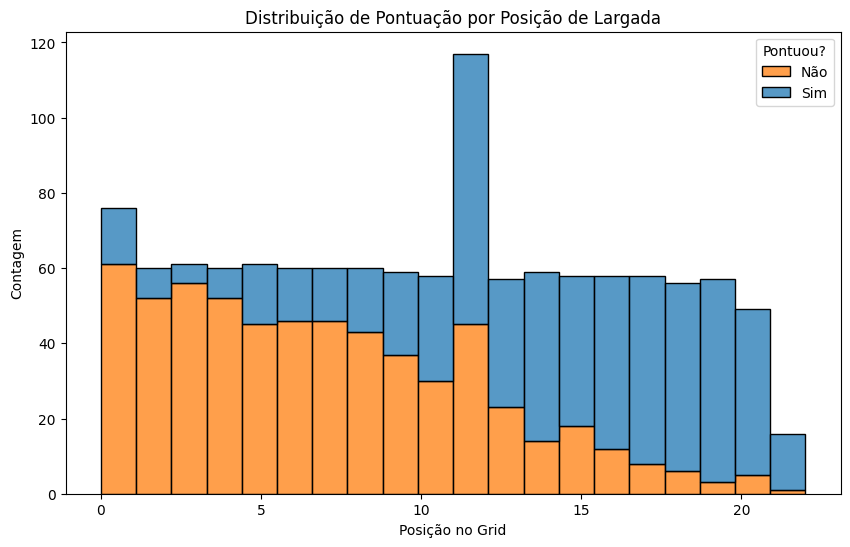

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_final, x='grid', hue='Pontuou', multiple='stack', bins=20)
plt.title('Distribuição de Pontuação por Posição de Largada')
plt.xlabel('Posição no Grid')
plt.ylabel('Contagem')
plt.legend(title='Pontuou?', labels=['Não', 'Sim'])
plt.show()

# Divisão Treino e Teste

In [12]:
from sklearn.model_selection import train_test_split

X = df_final.drop('Pontuou', axis=1)
y = df_final['Pontuou']

# 80% treino, 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Treinamento e Avaliação

Regressão Logística, Árvore, SVM e MLP.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

models = {
    "Regressão Logística": LogisticRegression(),
    "Árvore de Decisão": DecisionTreeClassifier(max_depth=5), 
    "SVM": SVC(),
    "MLP (Rede Neural)": MLPClassifier(hidden_layer_sizes=(10,10), max_iter=500)
}

results = {}

for name, model in models.items():
    # Treinar
    model.fit(X_train, y_train)
    
    # Prever
    y_pred = model.predict(X_test)
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"--- {name} ---")
    print(f"Acurácia: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Matriz de Confusão (Visual simples)
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

--- Regressão Logística ---
Acurácia: 0.7875
              precision    recall  f1-score   support

           0       0.78      0.81      0.80       122
           1       0.80      0.76      0.78       118

    accuracy                           0.79       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.79      0.79      0.79       240

Matriz de Confusão:
[[99 23]
 [28 90]]


--- Árvore de Decisão ---
Acurácia: 0.7667
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       122
           1       0.79      0.71      0.75       118

    accuracy                           0.77       240
   macro avg       0.77      0.77      0.77       240
weighted avg       0.77      0.77      0.77       240

Matriz de Confusão:
[[100  22]
 [ 34  84]]


--- SVM ---
Acurácia: 0.7917
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       122
           1       0.79      0.78 

# Análise de Resultados

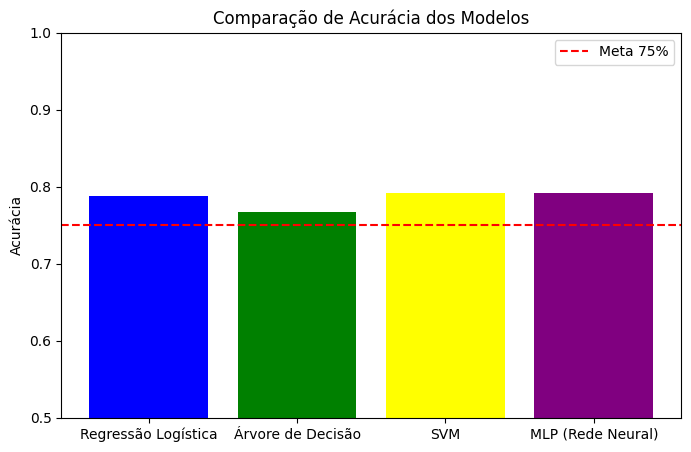

In [15]:
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'yellow', 'purple'])
plt.title('Comparação de Acurácia dos Modelos')
plt.ylabel('Acurácia')
plt.ylim(0.5, 1.0) 
plt.axhline(y=0.75, color='r', linestyle='--', label='Meta 75%') 
plt.legend()
plt.show()

# Curiosidades do autor

In [ ]:
print("Treinando de novo...")
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)

mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
print("Modelos prontos!")

# dados de teste
df_analise = df_clean.loc[y_test.index].copy()

races_ref = pd.read_csv(r'dataset\races.csv', encoding='latin-1')
drivers_ref = pd.read_csv(r'dataset\drivers.csv', encoding='latin-1')
constructors_ref = pd.read_csv(r'dataset\constructors.csv', encoding='latin-1')

# merges
df_analise = pd.merge(df_analise, races_ref[['race_id', 'race_name']], on='race_id', how='left')
df_analise = pd.merge(df_analise, drivers_ref[['driver_id', 'givenName', 'familyName']], on='driver_id', how='left')
constructors_ref = constructors_ref.rename(columns={'name': 'TeamName'})
df_analise = pd.merge(df_analise, constructors_ref[['constructor_id', 'TeamName']], on='constructor_id', how='left')
df_analise['Piloto'] = df_analise['givenName'] + ' ' + df_analise['familyName']

# Previsões
df_analise['Pred_Logistica'] = log_reg.predict(X_test)
df_analise['Pred_Arvore'] = tree.predict(X_test)
df_analise['Pred_SVM'] = svm.predict(X_test)
df_analise['Pred_MLP'] = mlp.predict(X_test)

# Mapear 0/1 para Texto
mapa = {0: 'Não', 1: 'Sim'}
cols_map = ['Pontuou', 'Pred_Logistica', 'Pred_Arvore', 'Pred_SVM', 'Pred_MLP']
for col in cols_map:
    df_analise[col] = df_analise[col].map(mapa)

colunas_finais = ['season', 'race_name', 'Piloto', 'TeamName', 'grid', 
                  'Pontuou', 'Pred_Logistica', 'Pred_Arvore', 'Pred_SVM', 'Pred_MLP']

df_exibicao = df_analise[colunas_finais].rename(columns={
    'season': 'Ano',
    'race_name': 'GP',
    'TeamName': 'Equipe',
    'grid': 'Largada',
    'Pontuou': 'REALIDADE'
})

print("\nO QUE ACONTECEU vs O QUE A IA PREVIU")
display(df_exibicao.sample(15))

# Curiosidade do autor - Maiores pontuadores da era híbrida
print("\nOP 10 MAIORES PONTUADORES (2014-2024)")
top_scorers = df_clean.groupby('driver_id')['points'].sum().sort_values(ascending=False).head(10)
top_scorers_names = pd.merge(top_scorers, drivers_ref[['driver_id', 'givenName', 'familyName']], on='driver_id')
top_scorers_names['Nome'] = top_scorers_names['givenName'] + ' ' + top_scorers_names['familyName']
print(top_scorers_names[['Nome', 'points']])

Treinando de novo...
Modelos prontos!

O QUE ACONTECEU vs O QUE A IA PREVIU


,Ano,GP,Piloto,Equipa,Largada,REALIDADE,Pred_Logistica,Pred_Arvore,Pred_SVM,Pred_MLP
125,2025,Saudi Arabian Grand Prix,Lewis Hamilton,Ferrari,7,Sim,Sim,Sim,Sim,Sim
27,2019,Azerbaijan Grand Prix,Alexander Albon,Toro Rosso,11,Não,Não,Não,Não,Não
68,2019,Chinese Grand Prix,Alexander Albon,Toro Rosso,0,Sim,Sim,Não,Sim,Sim
224,2016,Spanish Grand Prix,Sergio PÃ©rez,Force India,9,Sim,Sim,Sim,Sim,Sim
229,2020,Styrian Grand Prix,Lewis Hamilton,Mercedes,1,Sim,Sim,Sim,Sim,Sim
136,2020,Hungarian Grand Prix,Lance Stroll,Racing Point,3,Sim,Sim,Sim,Sim,Sim
93,2017,Spanish Grand Prix,Sebastian Vettel,Ferrari,2,Sim,Sim,Sim,Sim,Sim
45,2017,Bahrain Grand Prix,Valtteri Bottas,Mercedes,1,Sim,Sim,Sim,Sim,Sim
212,2018,Australian Grand Prix,Romain Grosjean,Haas F1 Team,6,Não,Sim,Sim,Sim,Sim
233,2020,Hungarian Grand Prix,Alexander Albon,Red Bull,13,Sim,Não,Sim,Não,Não



OP 10 MAIORES PONTUADORES (2014-2024)
               Nome  points
0    Lewis Hamilton   906.0
1    Max Verstappen   733.0
2   Valtteri Bottas   483.0
3  Sebastian Vettel   461.0
4     Sergio PÃ©rez   399.0
5   Charles Leclerc   389.0
6      Lando Norris   315.0
7      Nico Rosberg   313.0
8      Carlos Sainz   277.0
9  Daniel Ricciardo   254.0
